(pymc_aesara)=

# PyMC and Aesara

**Authors:** [Ricardo Vieira](https://github.com/ricardoV94) and [Juan Orduz](https://juanitorduz.github.io/)

In this notebook we want to give an introduction of how PyMC models translate to Aesara graphs. The purpose is not to give a detailed description of all [`aesara`](https://github.com/aesara-devs/aesara)'s capabilities but rather focus on the main concepts to understand its connection with PyMC. For a more detailed description of the project please refer to the official documentation.

## Prepare Notebook

First import the required libraries.

In [7]:
import aesara
import aesara.tensor as at
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats


print(
    f"""
# Aesara version: {aesara.__version__}
# PyMC version: {pm.__version__}
"""
)


# Aesara version: 2.7.9
# PyMC version: 4.1.4



## Introduction to Aesara

We start by looking into `aesara`. According to their documentation

> Aesara is a Python library that allows one to define, optimize, and efficiently evaluate mathematical expressions involving multi-dimensional arrays.

![aesara logo](https://raw.githubusercontent.com/aesara-devs/aesara/main/doc/images/aesara_logo_2400.png)

### A simple example

To begin, we define some aesara tensors and show how to perform some basic operations.

In [8]:
x = at.scalar(name="x")
y = at.vector(name="y")

print(
    f"""
x type: {x.type}
x name = {x.name}
---
y type: {y.type}
y name = {y.name}
"""
)


x type: TensorType(float64, ())
x name = x
---
y type: TensorType(float64, (None,))
y name = y



Now that we have defined the `x` and `y` tensors, we can create a new one by adding them together.

In [9]:
z = x + y
z.name = "x + y"

To make the computation a bit more complex let us take the logarithm of the resulting tensor.

In [10]:
w = at.log(z)
w.name = "log(x + y)"

We can use the {func}`~aesara.dprint` function to print the computational graph of any given tensor.

In [11]:
aesara.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'
 |Elemwise{add,no_inplace} [id B] 'x + y'
   |InplaceDimShuffle{x} [id C]
   | |x [id D]
   |y [id E]


Note that this graph does not do any computation (yet!). It is simply defining the sequence of steps to be done. We can use {func}`~aesara.function` to define a callable object so that we can push values trough the graph.

In [12]:
f = aesara.function(inputs=[x, y], outputs=w)

Now that the graph is compiled, we can push some concrete values:

In [13]:
f(x=0, y=[1, np.e])

array([0., 1.])

:::{tip}
Sometimes we just want to debug, we can use {meth}`~aesara.graph.basic.Variable.eval` for that:
:::

In [14]:
w.eval({x: 0, y: [1, np.e]})

array([0., 1.])

You can set intermediate values as well

In [15]:
w.eval({z: [1, np.e]})

array([0., 1.])

### Aesara is clever!

One of the most important features of `aesara` is that it can automatically optimize the mathematical operations inside a graph. Let's consider a simple example:

In [16]:
a = at.scalar(name="a")
b = at.scalar(name="b")

c = a / b
c.name = "a / b"

aesara.dprint(c)

Elemwise{true_div,no_inplace} [id A] 'a / b'
 |a [id B]
 |b [id C]


Now let us multiply `b` times `c`. This should result in simply `a`.

In [17]:
d = b * c
d.name = "b * c"

aesara.dprint(d)

Elemwise{mul,no_inplace} [id A] 'b * c'
 |b [id B]
 |Elemwise{true_div,no_inplace} [id C] 'a / b'
   |a [id D]
   |b [id B]


The graph shows the full computation, but once we compile it the operation becomes the identity on `a` as expected.

In [18]:
g = aesara.function(inputs=[a, b], outputs=d)

aesara.dprint(g)

DeepCopyOp [id A] 'a' 0
 |a [id B]


### What is in an Aesara graph?

The following diagram shows the basic structure of an `aesara` graph.

![aesara graph](https://raw.githubusercontent.com/aesara-devs/aesara/main/doc/tutorial/apply.png)

We can can make these concepts more tangible by explicitly indicating them in the first example from the section above. Let us compute the graph components for the tensor `z`. 

In [19]:
print(
    f"""
z type: {z.type}
z name = {z.name}
z owner = {z.owner}
z owner inputs = {z.owner.inputs}
z owner op = {z.owner.op}
z owner output = {z.owner.outputs}
"""
)


z type: TensorType(float64, (None,))
z name = x + y
z owner = Elemwise{add,no_inplace}(InplaceDimShuffle{x}.0, y)
z owner inputs = [InplaceDimShuffle{x}.0, y]
z owner op = Elemwise{add,no_inplace}
z owner output = [x + y]



The following code snippet helps us understand these concepts by going through the computational graph of `w`. The actual code is not as important here, the focus is on the outputs.

In [20]:
# start from the top
stack = [w]

while stack:
    print("---")
    var = stack.pop(0)
    print(f"Checking variable {var} of type {var.type}")
    # check variable is not a root variable
    if var.owner is not None:
        print(f" > Op is {var.owner.op}")
        # loop over the inputs
        for i, input in enumerate(var.owner.inputs):
            print(f" > Input {i} is {input}")
            stack.append(input)
    else:
        print(f" > {var} is a root variable")

---
Checking variable log(x + y) of type TensorType(float64, (None,))
 > Op is Elemwise{log,no_inplace}
 > Input 0 is x + y
---
Checking variable x + y of type TensorType(float64, (None,))
 > Op is Elemwise{add,no_inplace}
 > Input 0 is InplaceDimShuffle{x}.0
 > Input 1 is y
---
Checking variable InplaceDimShuffle{x}.0 of type TensorType(float64, (1,))
 > Op is InplaceDimShuffle{x}
 > Input 0 is x
---
Checking variable y of type TensorType(float64, (None,))
 > y is a root variable
---
Checking variable x of type TensorType(float64, ())
 > x is a root variable


Note that this is very similar to the output of {func}`~aesara.dprint` function introduced above.

In [21]:
aesara.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'
 |Elemwise{add,no_inplace} [id B] 'x + y'
   |InplaceDimShuffle{x} [id C]
   | |x [id D]
   |y [id E]


### Graph manipulation 101

Another interesting feature of Aesara is the ability to manipulate the computational graph, something that is not possible with TensorFlow or PyTorch. Here we continue with the example above in order to illustrate the main idea around this technique.

In [22]:
# get input tensors
list(aesara.graph.graph_inputs(graphs=[w]))

[x, y]

As a simple example, let's add an {func}`~aesara.tensor.exp` before the {func}`~aesara.tensor.log` (to get the identity function).

In [23]:
parent_of_w = w.owner.inputs[0]  # get z tensor
new_parent_of_w = at.exp(parent_of_w)  # modify the parent of w
new_parent_of_w.name = "exp(x + y)"

Note that the graph of `w` has actually not changed:

In [24]:
aesara.dprint(w)

Elemwise{log,no_inplace} [id A] 'log(x + y)'
 |Elemwise{add,no_inplace} [id B] 'x + y'
   |InplaceDimShuffle{x} [id C]
   | |x [id D]
   |y [id E]


To modify the graph we need to use the {func}`~aesara.clone_replace` function, which *returns a copy of the initial subgraph with the corresponding substitutions.*

In [25]:
new_w = aesara.clone_replace(output=[w], replace={parent_of_w: new_parent_of_w})[0]
new_w.name = "log(exp(x + y))"
aesara.dprint(new_w)

Elemwise{log,no_inplace} [id A] 'log(exp(x + y))'
 |Elemwise{exp,no_inplace} [id B] 'exp(x + y)'
   |Elemwise{add,no_inplace} [id C] 'x + y'
     |InplaceDimShuffle{x} [id D]
     | |x [id E]
     |y [id F]


Finally, we can test the modified graph by passing some input to the new graph.

In [26]:
new_w.eval({x: 0, y: [1, np.e]})

array([1.        , 2.71828183])

As expected, the new graph is just the identity function.

:::{note}
Again, note that `aesara` is clever enough to omit the `exp` and `log` once we compile the function.
:::

In [27]:
f = aesara.function(inputs=[x, y], outputs=new_w)

aesara.dprint(f)

Elemwise{add,no_inplace} [id A] 'x + y' 1
 |InplaceDimShuffle{x} [id B] 0
 | |x [id C]
 |y [id D]


In [28]:
f(x=0, y=[1, np.e])

array([1.        , 2.71828183])

### Aesara RandomVariables

Now that we have seen aesara's basics we want to move in the direction of random variables.

How do we generate random numbers in [`numpy`](https://github.com/numpy/numpy)? To illustrate it we can sample from a normal distribution:

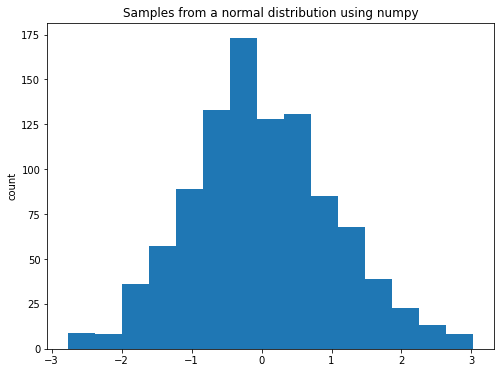

In [29]:
a = np.random.normal(loc=0, scale=1, size=1_000)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(a, color="C0", bins=15)
ax.set(title="Samples from a normal distribution using numpy", ylabel="count");

Now let's try to do it in Aesara.

In [30]:
y = at.random.normal(loc=0, scale=1, name="y")
y.type

TensorType(float64, ())

Next, we show the graph using {func}`~aesara.dprint`.

In [31]:
aesara.dprint(y)

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'y'
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x1300F9820>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{1} [id F]


The inputs are always in the following order:
1. `rng` shared variable
2. `size`
3. `dtype` (number code)
4. `arg1`
5. `arg2`
6. `argn`

We *could* sample by calling {meth}`~aesara.graph.basic.Variable.eval`. on the random variable.

In [32]:
y.eval()

array(0.30189123)

Note however that these samples are always the same!

In [33]:
for i in range(10):
    print(f"Sample {i}: {y.eval()}")

Sample 0: 0.30189122572724103
Sample 1: 0.30189122572724103
Sample 2: 0.30189122572724103
Sample 3: 0.30189122572724103
Sample 4: 0.30189122572724103
Sample 5: 0.30189122572724103
Sample 6: 0.30189122572724103
Sample 7: 0.30189122572724103
Sample 8: 0.30189122572724103
Sample 9: 0.30189122572724103


We always get the same samples! This has to do with the random seed step in the graph, i.e. `RandomGeneratorSharedVariable` (we will not go deeper into this subject here). We will show how to generate different samples with `pymc` below.

---

## PyMC

![pymc logo](https://raw.githubusercontent.com/pymc-devs/pymc/main/docs/logos/PyMC.png)

To do so, we start by defining a `pymc` normal distribution.

In [34]:
x = pm.Normal.dist(mu=0, sigma=1)
aesara.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A]
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x13026D2E0>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{1.0} [id F]


Observe that `x` is just a normal `RandomVariable` and which is the same as `y` except for the `rng`.

We can try to generate samples by calling {meth}`~aesara.graph.basic.Variable.eval` as above.

In [35]:
for i in range(10):
    print(f"Sample {i}: {x.eval()}")

Sample 0: -2.237598162546344
Sample 1: -2.237598162546344
Sample 2: -2.237598162546344
Sample 3: -2.237598162546344
Sample 4: -2.237598162546344
Sample 5: -2.237598162546344
Sample 6: -2.237598162546344
Sample 7: -2.237598162546344
Sample 8: -2.237598162546344
Sample 9: -2.237598162546344


As before we get the same value for all iterations. The correct way to generate random samples is using {func}`~pymc.draw`.

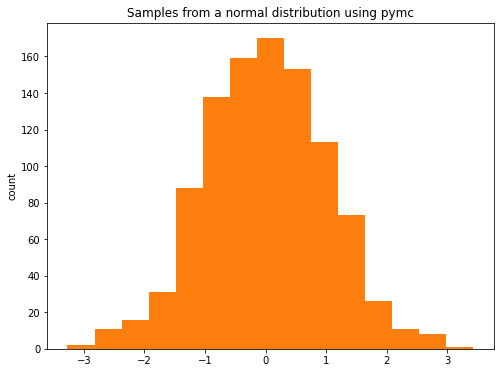

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(pm.draw(x, draws=1_000), color="C1", bins=15)
ax.set(title="Samples from a normal distribution using pymc", ylabel="count");

Yay! We learned how to sample from a `pymc` distribution!

### What is going on behind the scenes?

We can now look into how this is done inside a {class}`~pymc.Model`.

In [37]:
with pm.Model() as model:
    z = pm.Normal(name="z", mu=np.array([0, 0]), sigma=np.array([1, 2]))

aesara.dprint(x)

normal_rv{0, (0, 0), floatX, False}.1 [id A]
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x130316580>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{0} [id E]
 |TensorConstant{1.0} [id F]


We are just creating random variables like we saw before, but now registering them in a `pymc` model. To extract the list of random variables we can simply do:

In [38]:
model.basic_RVs

[z]

In [39]:
aesara.dprint(model.basic_RVs[0])

normal_rv{0, (0, 0), floatX, False}.1 [id A] 'z'
 |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x130396040>) [id B]
 |TensorConstant{[]} [id C]
 |TensorConstant{11} [id D]
 |TensorConstant{(2,) of 0} [id E]
 |TensorConstant{[1. 2.]} [id F]


We can try to sample via {meth}`~aesara.graph.basic.Variable.eval` as above and it is no surprise that we are getting the same samples at each iteration.

In [40]:
for i in range(10):
    print(f"Sample {i}: {z.eval()}")

Sample 0: [-0.14109248  1.10120293]
Sample 1: [-0.14109248  1.10120293]
Sample 2: [-0.14109248  1.10120293]
Sample 3: [-0.14109248  1.10120293]
Sample 4: [-0.14109248  1.10120293]
Sample 5: [-0.14109248  1.10120293]
Sample 6: [-0.14109248  1.10120293]
Sample 7: [-0.14109248  1.10120293]
Sample 8: [-0.14109248  1.10120293]
Sample 9: [-0.14109248  1.10120293]


Again, the correct way of sampling is via {func}`~pymc.draw`. 

In [41]:
for i in range(10):
    print(f"Sample {i}: {pm.draw(z)}")

Sample 0: [-0.30763395 -0.03785518]
Sample 1: [ 1.65868277 -2.89168795]
Sample 2: [ 0.60497487 -2.01427486]
Sample 3: [-1.00668317  1.17879995]
Sample 4: [0.31450361 1.08257152]
Sample 5: [ 0.48597109 -4.1494794 ]
Sample 6: [-1.37987128  0.80704246]
Sample 7: [2.49376802 3.16863565]
Sample 8: [0.88427773 1.99857046]
Sample 9: [ 1.01287644 -0.99032698]


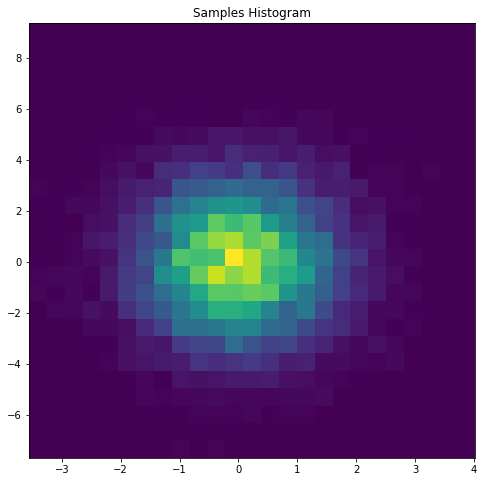

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
z_draws = pm.draw(vars=z, draws=10_000)
ax.hist2d(x=z_draws[:, 0], y=z_draws[:, 1], bins=25)
ax.set(title="Samples Histogram");

### Enough with Random Variables, I want to see some (log)probabilities!

Recall we have defined the following model above:

In [43]:
model

`pymc` is able to convert `RandomVariable`s to their respective probability functions. One simple way is to use {func}`~pymc.logp`, which takes as first input a RandomVariable, and as second input the value at which the logp is evaluated (we will discuss this in more detail later).

In [44]:
z_value = at.vector(name="z")
z_logp = pm.logp(rv=z, value=z_value)

`z_logp` contains the Aesara graph that represents the log-probability of the normal random variable `z`, evaluated at `z_value`.

In [45]:
aesara.dprint(z_logp)

Check{sigma > 0} [id A] 'z_logprob'
 |Elemwise{sub,no_inplace} [id B]
 | |Elemwise{sub,no_inplace} [id C]
 | | |Elemwise{mul,no_inplace} [id D]
 | | | |InplaceDimShuffle{x} [id E]
 | | | | |TensorConstant{-0.5} [id F]
 | | | |Elemwise{pow,no_inplace} [id G]
 | | |   |Elemwise{true_div,no_inplace} [id H]
 | | |   | |Elemwise{sub,no_inplace} [id I]
 | | |   | | |z [id J]
 | | |   | | |TensorConstant{(2,) of 0} [id K]
 | | |   | |TensorConstant{[1. 2.]} [id L]
 | | |   |InplaceDimShuffle{x} [id M]
 | | |     |TensorConstant{2} [id N]
 | | |InplaceDimShuffle{x} [id O]
 | |   |Elemwise{log,no_inplace} [id P]
 | |     |Elemwise{sqrt,no_inplace} [id Q]
 | |       |TensorConstant{6.283185307179586} [id R]
 | |Elemwise{log,no_inplace} [id S]
 |   |TensorConstant{[1. 2.]} [id L]
 |All [id T]
   |Elemwise{gt,no_inplace} [id U]
     |TensorConstant{[1. 2.]} [id L]
     |InplaceDimShuffle{x} [id V]
       |TensorConstant{0.0} [id W]


:::{tip}
There is also a handy `pymc` function to compute the log cumulative probability of a random variable {func}`~pymc.logcdf`.

Observe that, as explained at the beginning, there has been no computation yet. The actual computation is performed after compiling and passing the input. For illustration purposes alone, we will again use the handy {meth}`~aesara.graph.basic.Variable.eval` method.

In [46]:
z_logp.eval({z_value: [0, 0]})

array([-0.91893853, -1.61208571])

This is nothing else than evaluating the log probability of a normal distribution.

In [47]:
scipy.stats.norm.logpdf(x=np.array([0, 0]), loc=np.array([0, 0]), scale=np.array([1, 2]))

array([-0.91893853, -1.61208571])

`pymc` models provide some helpful routines to facilitating the conversion of `RandomVariable`s to probability functions. {meth}`~pymc.Model.logp`, for instance can be used to extract the joint probability of all variables in the model:

In [48]:
aesara.dprint(model.logp(sum=False))

Elemwise{mul,no_inplace} [id A]
 |Check{sigma > 0} [id B] 'z_logprob'
 | |Elemwise{sub,no_inplace} [id C]
 | | |Elemwise{sub,no_inplace} [id D]
 | | | |Elemwise{mul,no_inplace} [id E]
 | | | | |InplaceDimShuffle{x} [id F]
 | | | | | |TensorConstant{-0.5} [id G]
 | | | | |Elemwise{pow,no_inplace} [id H]
 | | | |   |Elemwise{true_div,no_inplace} [id I]
 | | | |   | |Elemwise{sub,no_inplace} [id J]
 | | | |   | | |z [id K]
 | | | |   | | |TensorConstant{(2,) of 0} [id L]
 | | | |   | |TensorConstant{[1. 2.]} [id M]
 | | | |   |InplaceDimShuffle{x} [id N]
 | | | |     |TensorConstant{2} [id O]
 | | | |InplaceDimShuffle{x} [id P]
 | | |   |Elemwise{log,no_inplace} [id Q]
 | | |     |Elemwise{sqrt,no_inplace} [id R]
 | | |       |TensorConstant{6.283185307179586} [id S]
 | | |Elemwise{log,no_inplace} [id T]
 | |   |TensorConstant{[1. 2.]} [id M]
 | |All [id U]
 |   |Elemwise{gt,no_inplace} [id V]
 |     |TensorConstant{[1. 2.]} [id M]
 |     |InplaceDimShuffle{x} [id W]
 |       |TensorConst

Because we only have one variable, this function is equivalent to what we obtained by manually calling `pm.logp` before. We can also use a helper {meth}`~pymc.Model.compile_logp` to return an already compiled Aesara function of the model logp.

In [49]:
logp_function = model.compile_logp(sum=False)

This function expects a "point" dictionary as input. We could create it ourselves, but just to illustrate another useful {class}`~pymc.Model` method, let's call {meth}`~pymc.Model.initial_point`, which returns the point that most samplers use when deciding where to start sampling.

In [50]:
point = model.initial_point()
point

{'z': array([0., 0.])}

In [51]:
logp_function(point)

[array([-0.91893853, -1.61208571])]

### What are value variables and why are they important?

As he have seen above, a logp graph does not have random variables. Instead it's defined in terms of input (value) variables. When we want to sample, each random variable (RV) is replaced by a logp function evaluated at the respective input (value) variable. Let's see how this works through some examples. RV and value variables can be observed in these [`scipy`](https://github.com/scipy/scipy) operations:

In [52]:
rv = scipy.stats.norm(0, 1)

# Equivalent to rv = pm.Normal("rv", 0, 1)
scipy.stats.norm(0, 1)

In [53]:
# Equivalent to rv_draw = pm.draw(rv, 3)
rv.rvs(3)

array([-0.01634534,  0.89999837, -0.03039365])

In [54]:
# Equivalent to rv_logp = pm.logp(rv, 1.25)
rv.logpdf(1.25)

-1.7001885332046727

Next, let's look at how these value variables behave in a slightly more complex model.

In [55]:
with pm.Model() as model_2:
    mu = pm.Normal(name="mu", mu=0, sigma=2)
    sigma = pm.HalfNormal(name="sigma", sigma=3)
    x = pm.Normal(name="x", mu=mu, sigma=sigma)

Each model RV is related to a "value variable":

In [56]:
model_2.rvs_to_values

{mu: mu, sigma: sigma_log__, x: x}

Observe that for sigma the associated value is in the *log* scale as in practice we require unbounded values for NUTS sampling.

In [57]:
model_2.value_vars

[mu, sigma_log__, x]

Now that we know how to extract the model variables, we can compute the element-wise log-probability of the model for specific values.

In [58]:
# extract values as aesara.tensor.var.TensorVariable
mu_value = model_2.rvs_to_values[mu]
sigma_log_value = model_2.rvs_to_values[sigma]
x_value = model_2.rvs_to_values[x]
# element-wise log-probability of the model (we do not take te sum)
logp_graph = at.stack(model_2.logp(sum=False))
# evaluate by passing concrete values
logp_graph.eval({mu_value: 0, sigma_log_value: -10, x_value: 0})

array([ -1.61208571, -11.32440364,   9.08106147])

This equivalent to:

In [59]:
print(
    f"""
mu_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=2)}
sigma_log_value -> {- 10 + scipy.stats.halfnorm.logpdf(x=np.exp(-10), loc=0, scale=3)} 
x_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=np.exp(-10))}
"""
)


mu_value -> -1.612085713764618
sigma_log_value -> -11.324403641427345 
x_value -> 9.081061466795328



:::{Note}
For `sigma_log_value` we add the $-10$ term for the `scipy` and `aesara` to match because of the jacobian.
:::

As we already saw, we can also use the method {meth}`~pymc.Model.compile_logp` to obtain a compiled aesara function of the model logp, which takes a dictionary of `{value variable name : value}` as inputs:

In [60]:
model_2.compile_logp(sum=False)({"mu": 0, "sigma_log__": -10, "x": 0})

[array(-1.61208571), array(-11.32440364), array(9.08106147)]

The {class}`~pymc.Model` class also has methods to extract the gradient ({meth}`~pymc.Model.dlogp`) and the hessian ({meth}`~pymc.Model.d2logp`) of the logp.

If you want to go deeper into the internals of `aesara` RandomVariables and `pymc` distributions please take a look into the [distribution developer guide](implementing-a-distribution).